In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from matplotlib import pyplot as plt

# Задание 1

In [ ]:
def get_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform
    )
    return trainset, testset

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
        )

    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        return x

In [ ]:
import wandb
from torcheval.metrics.functional import multiclass_f1_score


def train_loop(dataloader, model, loss_fn, optimizer, device: str):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * dataloader.batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    wandb.log({"train_loss": train_loss / num_batches})


def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy, f1_score = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            f1_score += multiclass_f1_score(pred, y).item()

    test_loss /= num_batches
    accuracy /= size
    f1_score /= num_batches

    wandb.log(
        {"test_loss": test_loss, "test_accuracy": accuracy, "test_f1_score": f1_score}
    )

    print(
        f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [ ]:
%wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shadaevf (shadaevf-rtu-mirea) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
device = "cuda"


trainset, testset = get_data()

batch_size = 32
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)
net = Net()
net.to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

wandb.init(
    # Set the project where this run will be logged
    project="ML2_6",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name="experiment_1",
)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(trainloader, net, loss_fn, optimizer, device)
    test_loop(testloader, net, loss_fn, device)

torch.save(net.state_dict(), "model_weights.pth")
torch.save(optimizer.state_dict(), "optimizer_settings.pth")

wandb.finish()

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]
wandb: Currently logged in as: shadaevf (shadaevf-rtu-mirea) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1
-------------------------------
loss: 2.281420  [   32/50000]
loss: 2.346350  [  352/50000]
loss: 2.250696  [  672/50000]
loss: 2.249829  [  992/50000]
loss: 2.260210  [ 1312/50000]
loss: 2.115464  [ 1632/50000]
loss: 2.054138  [ 1952/50000]
loss: 2.173302  [ 2272/50000]
loss: 1.991207  [ 2592/50000]
loss: 2.168268  [ 2912/50000]
loss: 1.902736  [ 3232/50000]
loss: 2.104395  [ 3552/50000]
loss: 2.021287  [ 3872/50000]
loss: 2.091974  [ 4192/50000]
loss: 1.821663  [ 4512/50000]
loss: 1.812939  [ 4832/50000]
loss: 1.791943  [ 5152/50000]
loss: 1.900043  [ 5472/50000]
loss: 1.810103  [ 5792/50000]
loss: 2.028165  [ 6112/50000]
loss: 1.923087  [ 6432/50000]
loss: 1.903513  [ 6752/50000]
loss: 1.622651  [ 7072/50000]
loss: 1.732455  [ 7392/50000]
loss: 1.678696  [ 7712/50000]
loss: 1.892686  [ 8032/50000]
loss: 1.840698  [ 8352/50000]
loss: 1.680730  [ 8672/50000]
loss: 1.707998  [ 8992/50000]
loss: 1.781068  [ 9312/50000]
loss: 1.750542  [ 9632/50000]
loss: 1.553789  [ 9952/50000]


test_accuracy,▁▄▅▆▇▇▇███▇████▇████
test_f1_score,▁▄▅▆▇▇▇███▇████▇████
test_loss,█▅▄▃▂▁▁▁▂▂▃▂▃▂▃▄▄▄▅▆
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
test_accuracy,0.7067
test_f1_score,0.70667
test_loss,1.18486
train_loss,0.31825


In [ ]:
print(testset[0])

(tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
         [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
         [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
         ...,
         [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
         [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
         [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

        [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
         [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
         [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
         ...,
         [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
         [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
         [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],

        [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
         [-0.6000, -0.6863, -0.6471,  ..., -

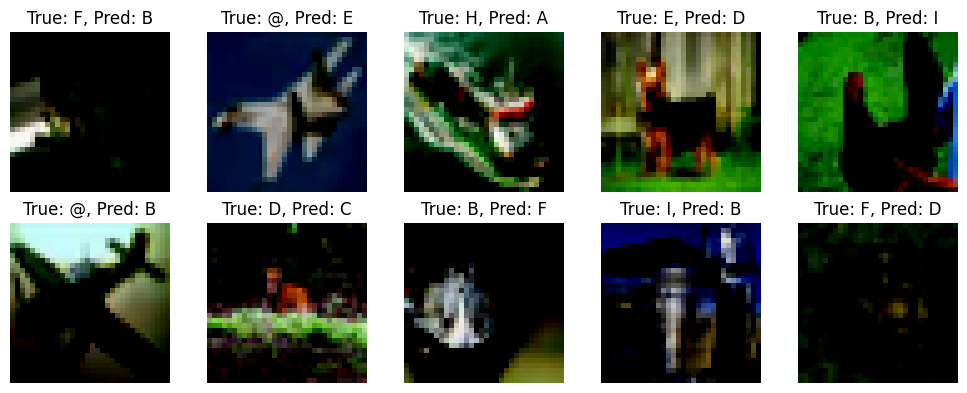

In [ ]:
incorrect_images = []  # Для хранения неверно классифицированных изображений
incorrect_labels = []  # Для хранения правильных меток
incorrect_preds = []  # Для хранения предсказанных меток
with torch.no_grad():
    for X, y in testset:
        X = X.to(device)
        pred = net(X.unsqueeze(0))
        if pred.argmax(1) != y:
            incorrect_images.append(X)
            incorrect_labels.append(y)
            incorrect_preds.append(pred.argmax(1).item())


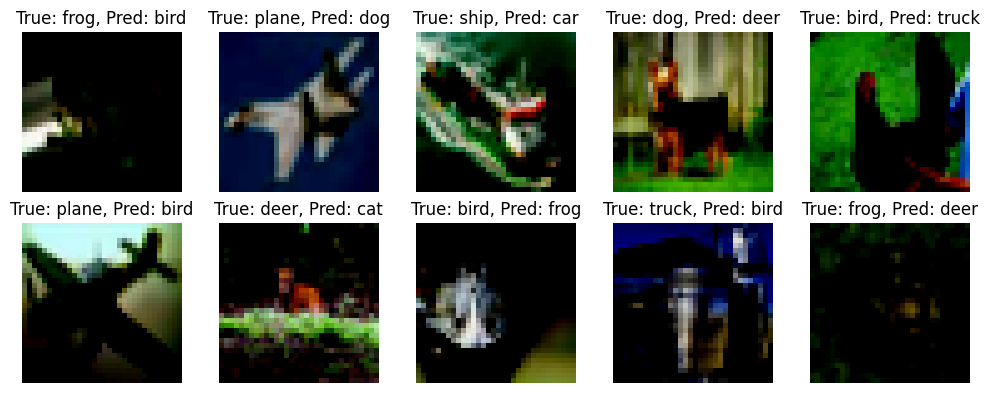

In [ ]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


# Выводим некорректные изображения
def display_incorrect_images(images, true_labels, pred_labels):
    plt.figure(figsize=(10, 4))
    for i in range(min(10, len(images))):  # Отобразить максимум 10 изображений
        plt.subplot(2, 5, i + 1)

        # Преобразуем формат изображения из (C, H, W) в (H, W, C)
        img = (
            images[i].permute(1, 2, 0) if images[i].dim() == 3 else images[i].squeeze()
        )

        plt.imshow(img.cpu())
        plt.title(f"True: {classes[true_labels[i]]}, Pred: {classes[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


display_incorrect_images(incorrect_images, incorrect_labels, incorrect_preds)

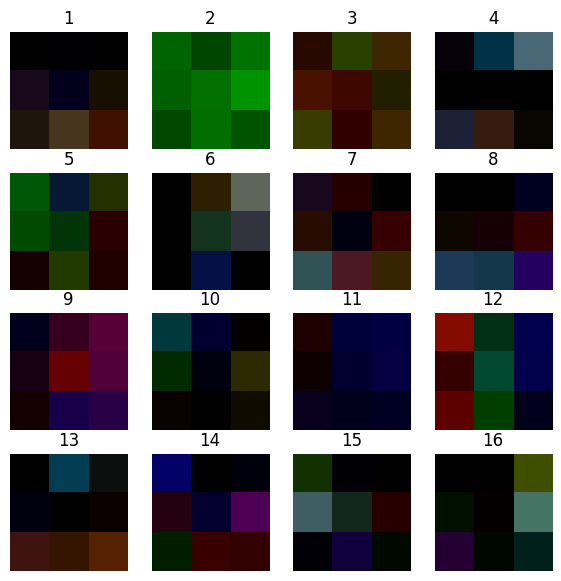

In [ ]:
weight = net.layers[0].weight.data.cpu().numpy()

figure = plt.figure(figsize=(7, 7))
cols, rows = 4, 4
for i in range(0, cols * rows):
    img = weight[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(i + 1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Задание 2

In [ ]:
def get_data(data_dir="./data"):
    transform = transforms.Compose([transforms.ToTensor()])
    target_transform = transforms.Lambda(lambda target: target - 1)

    trainset = torchvision.datasets.EMNIST(
        root=data_dir,
        split="letters",
        train=True,
        download=True,
        transform=transform,
        target_transform=target_transform,
    )

    testset = torchvision.datasets.EMNIST(
        root=data_dir,
        split="letters",
        train=False,
        download=True,
        transform=transform,
        target_transform=target_transform,
    )
    return trainset, testset

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        return x

In [ ]:
import wandb


def train_loop(dataloader, model, loss_fn, optimizer, device: str):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * dataloader.batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    wandb.log({"train_loss": train_loss / num_batches})


def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy, f1_score = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            f1_score += multiclass_f1_score(pred, y).item()

    test_loss /= num_batches
    accuracy /= size
    f1_score /= num_batches

    wandb.log(
        {"test_loss": test_loss, "test_accuracy": accuracy, "test_f1_score": f1_score}
    )

    print(
        f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [8]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shadaevf (shadaevf-rtu-mirea) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
device = "cuda"

trainset, testset = get_data()

batch_size = 64
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)
net = Net()
net.to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

wandb.init(
    # Set the project where this run will be logged
    project="ML2_6",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name="experiment_4",
)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(trainloader, net, loss_fn, optimizer, device)
    test_loop(testloader, net, loss_fn, device)

torch.save(net.state_dict(), "model_weights.pth")
torch.save(optimizer.state_dict(), "optimizer_settings.pth")

wandb.finish()

Epoch 1
-------------------------------
loss: 2.332447  [   64/50000]
loss: 2.263874  [  704/50000]
loss: 2.267533  [ 1344/50000]
loss: 2.232142  [ 1984/50000]
loss: 2.172933  [ 2624/50000]
loss: 2.154474  [ 3264/50000]
loss: 2.109859  [ 3904/50000]
loss: 2.097285  [ 4544/50000]
loss: 2.033288  [ 5184/50000]
loss: 1.984759  [ 5824/50000]
loss: 1.938342  [ 6464/50000]
loss: 2.022883  [ 7104/50000]
loss: 1.951597  [ 7744/50000]
loss: 2.039011  [ 8384/50000]
loss: 1.988176  [ 9024/50000]
loss: 2.110624  [ 9664/50000]
loss: 2.054007  [10304/50000]
loss: 1.861666  [10944/50000]
loss: 2.038445  [11584/50000]
loss: 1.858596  [12224/50000]
loss: 2.012595  [12864/50000]
loss: 1.998067  [13504/50000]
loss: 1.803963  [14144/50000]
loss: 1.698360  [14784/50000]
loss: 1.759032  [15424/50000]
loss: 1.834355  [16064/50000]
loss: 1.812987  [16704/50000]
loss: 1.901925  [17344/50000]
loss: 1.887118  [17984/50000]
loss: 1.803825  [18624/50000]
loss: 1.752515  [19264/50000]
loss: 1.789303  [19904/50000]


test_accuracy,▁▃▄▅▅▆▅▆▇▇▇▇▇▆▇▇████
test_f1_score,▁▃▄▅▅▆▅▆▇▇▇▇▇▆▇▇████
test_loss,█▆▅▄▄▃▄▃▂▂▂▂▂▂▂▂▁▁▁▁
train_loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
test_accuracy,0.6069
test_f1_score,0.60669
test_loss,1.12914
train_loss,1.04309


In [ ]:
incorrect_images = []  # Для хранения неверно классифицированных изображений
incorrect_labels = []  # Для хранения правильных меток
incorrect_preds = []  # Для хранения предсказанных меток
with torch.no_grad():
    for X, y in testset:
        X = X.to(device)
        pred = net(X.unsqueeze(0))
        if pred.argmax(1) != y:
            incorrect_images.append(X)
            incorrect_labels.append(y)
            incorrect_preds.append(pred.argmax(1).item())


8 1
0 8
6 4
3 4
5 3
8 6
5 3
7 9
4 2
5 4


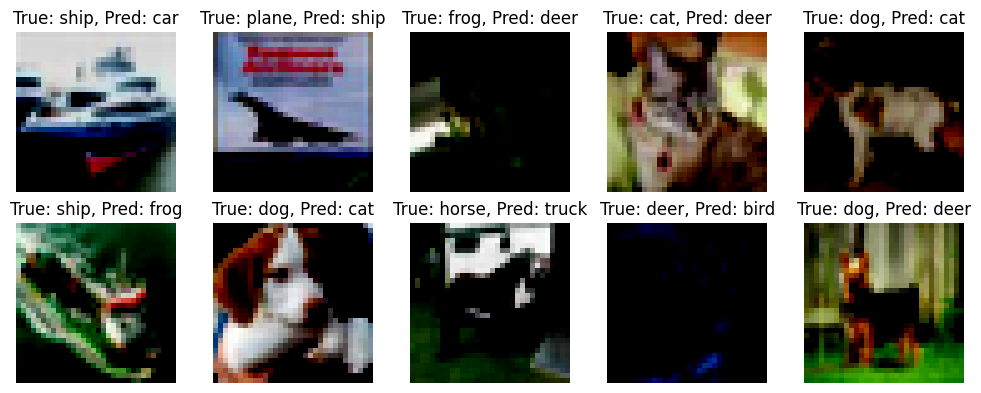

In [ ]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


# Выводим некорректные изображения
def display_incorrect_images(images, true_labels, pred_labels):
    plt.figure(figsize=(10, 4))
    for i in range(min(10, len(images))):  # Отобразить максимум 10 изображений
        plt.subplot(2, 5, i + 1)

        # Преобразуем формат изображения из (C, H, W) в (H, W, C)
        img = (
            images[i].permute(1, 2, 0) if images[i].dim() == 3 else images[i].squeeze()
        )

        plt.imshow(img.cpu())
        print(true_labels[i], pred_labels[i])
        plt.title(f"True: {classes[true_labels[i]]}, Pred: {classes[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


display_incorrect_images(incorrect_images, incorrect_labels, incorrect_preds)

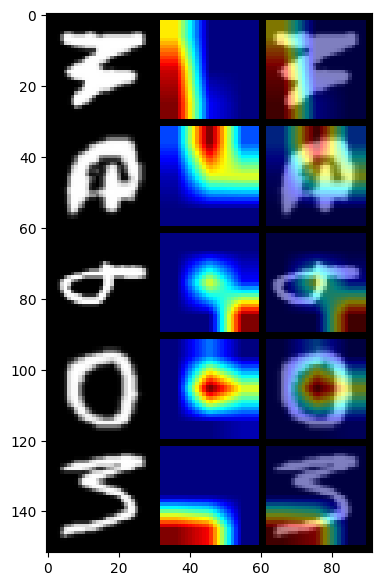

In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

target_layer = net.layers[6]
images = []
for i in range(5):
    gradcam = GradCAM(net, target_layer)
    torch_image = trainset[i][0].unsqueeze(dim=0).to(device)
    mask, _ = gradcam(torch_image)
    torch_image = torch_image.squeeze().repeat(3, 1, 1)
    heatmap, result = visualize_cam(mask, torch_image)
    images += [torch_image.to("cpu"), heatmap, result]

grid_image = make_grid(images, nrow=3)
plt.figure(figsize=(5, 7))
plt.imshow(transforms.ToPILImage()(grid_image))

In [ ]:
net.layers[6]

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))

In [12]:
wandb.finish()